In [1]:
#Rebekah Vinson HW_10


%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
from sklearn.linear_model import LinearRegression
import datetime as dt
from datetime import timedelta
import time
import seaborn as sns

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [12]:
#Worked as a group in hackathon 

#Design a query to retrieve the last 12 months of precipitation data and plot the results
date_max_mnth = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#Max Date to calculate one year ago
max_date = dt.datetime.strptime(date_max_mnth, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
year_diff = max_date - dt.timedelta(days=365)


# Query to retrieves the data and precipitation scores with orders by date
date_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >=year_diff).\
    order_by(Measurement.date).all()
 

# Save the query results as a Pandas DataFrame and set the index to the date column
date_scoresDF = pd.DataFrame(date_scores,columns=['date', 'precipitation'])

#I wanted to add the year, day and month to the graph
date_scoresDF['date'] = pd.to_datetime(date_scoresDF['date'], format='%Y-%m-%d')

# Sort the dataframe by date
date_scoresDF = date_scoresDF.sort_values(by='date',ascending=True)




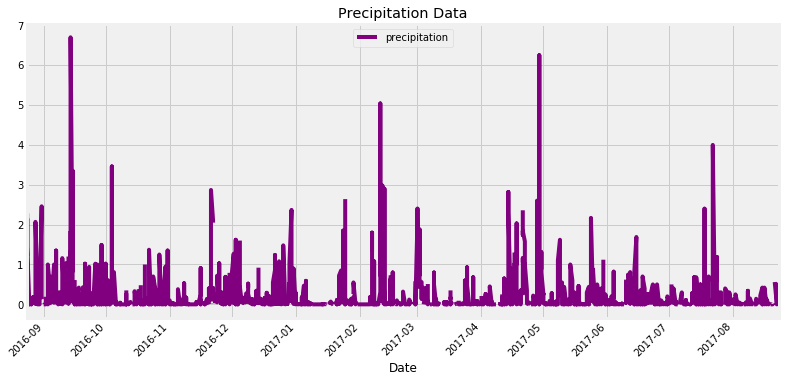

In [13]:
#Graph needed more information and configuration: color, actual date for 'Date' and placement of legend
#citation for graph -Trips Per Day graph: https://github.com/ahmedgurbuz/SMU-Project1-Group3/blob/master/NYC%20Uber%20Analysis.ipynb


date_scoresDF.plot('date', 'precipitation',figsize = (12,6), color="purple")
plt.xlabel("Date")
plt.title("Precipitation Data")
plt.legend(loc='upper center')
plt.xticks(rotation=45)
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_scoresDF.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
a_stations =session.query(Measurement.station).distinct().count()
print(f"There are {a_stations} stations available ")

There are 9 stations available 


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#please use this citation func - func.count and previous lessons: https://docs.sqlalchemy.org/en/13/core/functions.html

mst_act_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"The most active stations are: ")
mst_act_stations

The most active stations are: 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
#1.create a variable first
the_mst_act_station = mst_act_stations[0][0]
                                                                                                
the_mst_act_station

'USC00519281'

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, http://localhost:8888/notebooks/Desktop/PREWORK_RGV/Images/station-histogram.png
# highest temperature recorded, and average temperature of the most active station?

act_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == the_mst_act_station).all()

print(f"For station id {the_mst_act_station}, the lowest temp recorded is {act_station_temps[0][0]} degrees, the highest temp recorded is {act_station_temps[0][1]} degrees, and the average temp recorded is {round (act_station_temps [0][2],1)} degrees.")

For station id USC00519281, the lowest temp recorded is 54.0 degrees, the highest temp recorded is 85.0 degrees, and the average temp recorded is 71.7 degrees.


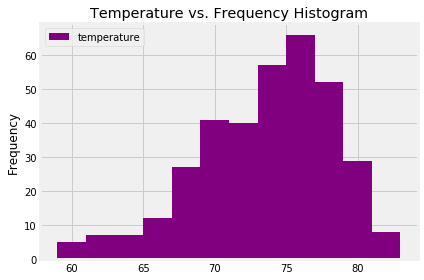

In [19]:


# Choose the station with the highest number of temperature observations.
station_highest_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_highest_observations= station_highest_observations[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.tobs).filter(Measurement.date >= year_diff).filter(Measurement.station == the_mst_act_station).all()
temp_observationsDF = pd.DataFrame(temp_observations, columns=['temperature'])

  #Used purple for Alexander  
temp_observationsDF.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", color= 'purple')
plt.tight_layout()
plt.show()


  

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip= calc_temps('2017-07-22','2018-08-01')




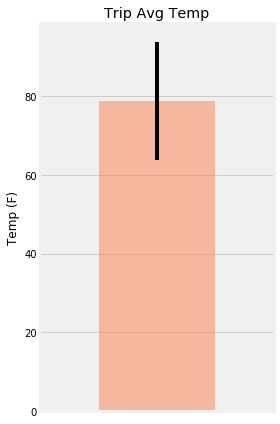

In [22]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])



# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-22','2017-08-01'))# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.07), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
